In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, MaxPool2D, LeakyReLU

In [2]:
joint_name = ['HeadF', 'HeadB', 'HeadL', 'SpineF', 'SpineM', 'SpineL', 
            'Offset1', 'Offset2', 'HipL', 'HipR', 'ElbowL', 'ArmL', 
            'ShoulderL', 'ShoulderR', 'ElbowR', 'ArmR', 'KneeR', 
            'KneeL', 'ShinL', 'ShinR']

joints_idx = [[1, 2], [2, 3], [1, 3], [2, 4], [1, 4], [3, 4], [4, 5], 
            [5, 6], [4, 7], [7, 8], [5, 8], [5, 7], [6, 8], [6, 9], 
            [6, 10], [11, 12], [4, 13], [4, 14], [11, 13], [12, 13], 
            [14, 15], [14, 16], [15, 16], [9, 18], [10, 17], [18, 19], 
            [17, 20]]

In [3]:
# Loading mat file and returning file
def loadMatFile(fileName, key):
    mat = loadmat(fileName)[key]
    print("Loaded:",fileName, key)
    return mat

In [4]:
# Plot 3D points given file and frame number
def plotKnownOrder(matFile, numb):
    mat = matFile[numb]
    x = mat[0]
    y = mat[1]
    z = mat[2]

    # loading plot
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # adding points, labels and lines
    try:
        ax.scatter(x,y,z, color='#ff5e5e', s =10, marker='x')
    except:
        pass
    # addLabels(ax, x, y, z)
    drawLines(ax, x, y, z)
    drawAllLines(ax, x, y, z)

    # Labeling plot
    ax.set_title("Rat positioning")
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    plt.show()

# Draw major lines in the rat model
def drawLines(ax,x, y, z):
    # run through all the connections to draw the points
    for i in range(len(joints_idx)):
        try: 
            # Getting both points to draw line
            idx = joints_idx[i]
            x_line = [x[idx[0]-1], x[idx[1]-1]]
            y_line = [y[idx[0]-1], y[idx[1]-1]]
            z_line = [z[idx[0]-1], z[idx[1]-1]]
            z_coord_1 = x[idx[0]-1], y[idx[0]-1], z[idx[0]-1]
            z_coord_2 = x[idx[1]-1], y[idx[1]-1], z[idx[1]-1]

            # Draw lines
            if i < 3: 
                ax.plot(x_line, y_line, z_line, c="#064ea1", linewidth=4)
            elif i < 6:
                ax.plot(x_line, y_line, z_line, c="#64ccd1", linewidth=4)
            else:
                ax.plot(x_line, y_line, z_line, c="#46b8a7", linewidth=4)
        except:
            pass

# Draw all line from every point 
def drawAllLines(ax,x, y, z):
    joint_len = len(joint_name)
    all_lines = []
    for i in range(joint_len):
        for j in range(joint_len):
            if (not([i,j] in all_lines)):
                x_line = [x[i], x[j]]
                y_line = [y[i], y[j]]
                z_line = [z[i], z[j]]
                ax.plot(x_line, y_line, z_line, color='#b1d8fc', linewidth=0.5)
                all_lines.append([i,j])
                all_lines.append([j,i])

In [5]:
# normalizes a matrix
def normalize(matrix):
    max_numb = max(matrix[~np.isnan(matrix)])
    norm = matrix/max_numb
    return np.array(norm)

In [6]:
from scipy.spatial.distance import cdist
# Get the distance to every single point 
def getAllDistances(matFile, numb):
    # print(numb)
    mat = matFile[numb]
    mat = mat.T
    dist = cdist(mat, mat, 'euclidean')
    # print(normalize(dist).shape)
    return normalize(dist)

In [7]:
# Get the absolute height difference to every single point 
def getAllHeights(matFile, numb):
    mat = matFile[numb]
    z = mat[2]
    reshaped = int(matFile.shape[2])
    height = []

    for i in range(reshaped):
        for j in range(reshaped):
            if np.nan in [z[i], z[j]]:
                height.append(np.nan)
            else:
                height.append(np.abs(z[i]-z[j]))

    # normalizes height data
    height = normalize(np.array(height).reshape(reshaped, reshaped))
    return height


In [8]:
# Get the angle to every single point 
def getAllAngles(matFile, numb):
    mat = matFile[numb]
    mat = mat.T
    angle = cdist(mat, mat, 'cosine')
    return normalize(angle)

In [9]:
def addNans(raw):
    raw_copy = np.array(raw.copy())

    for i in range(raw_copy.shape[0]):
        rand_numb = np.random.randint(0, 4)
        rand_index = random.sample(range(3, 20), rand_numb)
        for j in range(rand_numb):
            raw_copy[i][:,rand_index[j]] = np.nan
    return raw_copy


In [10]:
def getData(data, numb): 
    cnn_inputs = []
    for i in range(numb):
        dist = getAllDistances(data, i) 
        height = getAllHeights(data, i)
        angle = getAllAngles(data, i)
        # print(angle.shape)
        for j in range(0, data.shape[2]):
            temp = np.array([dist[j], height[j], angle[j]])
            first = temp[:,0:3]
            second = temp[:,3:20]
            first = first [ :, first[0].argsort()]
            second = second [ :, second[0].argsort()]
            output = np.concatenate((first, second), axis =1)
            cnn_inputs.append(output)

    # DIMENTION CHANGE
    # cnn_inputs = np.array(cnn_inputs)[:,:,:13]
    cnn_inputs = np.array(cnn_inputs)[:,:,:20]
    # cnn_inputs = np.array(cnn_inputs).reshape((numb*20, 39))
    cnn_inputs = np.array(cnn_inputs).reshape((numb*data.shape[2], 60))
    where_are_NaNs = np.isnan(cnn_inputs)
    cnn_inputs[where_are_NaNs] = 0
    return cnn_inputs


In [11]:
def oneFileTestTrain():
    mat_file = loadmat('mat_files/markerSplit_1_shuffled.mat')
    data = mat_file['alteredM']
    labels = mat_file['labelsM']

    # set numb of data used
    numb_train = 2000
    numb_test = 2000

    # find length of data
    mat_len = int(len(labels))
    mat_half = int(mat_len/2)

    # Take some frames from the list to use as trian and test data
    index_train = np.linspace(0, mat_half, num = numb_train, endpoint=False).astype(int)
    index_test = np.linspace(mat_half, mat_len, num = numb_test, endpoint=False).astype(int)
    pre_train_data = data[index_train]
    pre_train_labels = labels[index_train]
    pre_test_data = data[index_test]
    pre_test_labels = labels[index_test]

    print("Shape of pre_train_data:", pre_train_data.shape)
    print("Shape of pre_test_data:", pre_test_data.shape)
    print("Shape of pre_train_labels:", pre_train_labels.shape)
    print("Shape of pre_test_labels:", pre_test_labels.shape)
    return pre_train_data, pre_test_data, pre_train_labels, pre_test_labels

In [12]:
train_file = loadmat('mat_files/bigSet1.mat')
test_file = loadmat('mat_files/bigSet2.mat')

In [13]:
train_data = train_file['bigSet1']
test_data = test_file['bigSet2']
train_labels = train_file['labels1']
test_labels = test_file['labels2']
# set numb of data used
numb_train = 5000
numb_test = 1000

# Take some frames from the list to use as trian and test data
index_train = np.linspace(0, len(train_labels), num = numb_train, endpoint=False).astype(int)
index_test = np.linspace(0, len(test_labels), num = numb_test, endpoint=False).astype(int)
pre_train_data = train_data[index_train]
pre_train_labels = train_labels[index_train]
pre_test_data = test_data[index_test]
pre_test_labels = test_labels[index_test]

print("Shape of pre_train_data:", pre_train_data.shape)
print("Shape of pre_test_data:", pre_test_data.shape)
print("Shape of pre_train_labels:", pre_train_labels.shape)
print("Shape of pre_test_labels:", pre_test_labels.shape)


Shape of pre_train_data: (5000, 3, 20)
Shape of pre_test_data: (1000, 3, 20)
Shape of pre_train_labels: (5000, 20)
Shape of pre_test_labels: (1000, 20)


In [14]:
# Get measurement data for every 3D point
train_data = getData(pre_train_data, numb_train)
test_data = getData(pre_test_data, numb_test)

# Flatten the trian labels to fit dimentions of data
train_labels = pre_train_labels.flatten()[0:(numb_train*20)]-1
test_labels = pre_test_labels.flatten()[0:(numb_test*20)]-1

print("Shape of train_data:", train_data.shape)
print("Shape of test_data:", test_data.shape)
print("Shape of train_labels:", train_labels.shape)
print("Shape of test_labels:", test_labels.shape)

Shape of train_data: (100000, 60)
Shape of test_data: (20000, 60)
Shape of train_labels: (100000,)
Shape of test_labels: (20000,)


In [15]:
# Get index where the data is all 0
nans_train = np.sort(np.where(~train_data.any(axis=1))[0])[::-1]
nans_test = np.sort(np.where(~test_data.any(axis=1))[0])[::-1]

# Turn data into lists
train_data_new = list(train_data)
test_data_new = list(test_data)
train_labels_new = list(train_labels)
test_labels_new = list(test_labels)

# Remove the nan values 
for i in nans_train:
    train_data_new.pop(i)
    train_labels_new.pop(i)
for i in nans_test:
    test_data_new.pop(i)
    test_labels_new.pop(i)

# Turn data back into array
train_data_new = np.array(train_data_new)
train_labels_new = np.array(train_labels_new)
test_data_new = np.array(test_data_new)
test_labels_new = np.array(test_labels_new)

print("Shape of train_data_new:", train_data_new.shape)
print("Shape of test_data_new:", test_data_new.shape)
print("Shape of train_labels_new:", train_labels_new.shape)
print("Shape of test_labels_new:", test_labels_new.shape)

Shape of train_data_new: (91010, 60)
Shape of test_data_new: (18259, 60)
Shape of train_labels_new: (91010,)
Shape of test_labels_new: (18259,)


In [16]:
# Creates the ML training platform to predict rat joints
def ml_traning(train_data, train_labels, test_data, test_labels):
    # DIMENTION CHANGE
    # train_data = train_data.reshape(train_data.shape[0], 39)
    # test_data = test_data.reshape(test_data.shape[0], 39)
    train_data = train_data.reshape(train_data.shape[0], 60)
    test_data = test_data.reshape(test_data.shape[0], 60)
    train_data = train_data.astype('float32')
    test_data = test_data.astype('float32')

    model = createModel()
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(x=train_data,y=train_labels, verbose='auto', batch_size=20, epochs=20)
    
    output = model.evaluate(test_data, test_labels)
    print("Loss:", output[0])
    print("Accuracy:", output[1]*100)
    return model

# Creates the model for the CNN
def createModel():
    model = Sequential()
    model.add(Dense(80, activation= LeakyReLU()))
    model.add(Dense(320, activation= LeakyReLU()))
    model.add(Dropout(rate=0.25))
    model.add(Dense(80, activation= LeakyReLU()))
    model.add(Dense(len(joint_name), activation = "softmax"))
    return model

In [17]:
skeleton_model = ml_traning(train_data_new, train_labels_new, test_data_new, test_labels_new)

Epoch 1/20
4551/4551 [==============================] - 9s 2ms/step - loss: 1.3854 - accuracy: 0.5149
Epoch 2/20
4551/4551 [==============================] - 9s 2ms/step - loss: 1.0864 - accuracy: 0.6263
Epoch 3/20
4551/4551 [==============================] - 8s 2ms/step - loss: 0.9617 - accuracy: 0.6733
Epoch 4/20
4551/4551 [==============================] - 11s 2ms/step - loss: 0.8774 - accuracy: 0.7045
Epoch 5/20
4551/4551 [==============================] - 10s 2ms/step - loss: 0.8200 - accuracy: 0.7239
Epoch 6/20
4551/4551 [==============================] - 20s 4ms/step - loss: 0.7811 - accuracy: 0.7365
Epoch 7/20
4551/4551 [==============================] - 7s 2ms/step - loss: 0.7476 - accuracy: 0.7471
Epoch 8/20
4551/4551 [==============================] - 9s 2ms/step - loss: 0.7283 - accuracy: 0.7550
Epoch 9/20
4551/4551 [==============================] - 8s 2ms/step - loss: 0.7084 - accuracy: 0.7618
Epoch 10/20
4551/4551 [==============================] - 7s 2ms/step - loss: 0.

In [18]:
# Tests individual points and tells you if the CNN worked
def handTest(image_index, test_data, label, model, maxNumb):
    max_index = len(joint_name)*maxNumb-1
    if image_index <= max_index:
        predict(test_data, image_index, label, model)
    else:
        print("ERROR: Your predict_index must be below", max_index)

# Showing individual predictions
def predict(data, image_index, label, model):
    img = [data[image_index]]
    # DIMENTION CHANGE
    # img = np.array(img).reshape(3,13)
    img = np.array(img).reshape(3,20)
    plt.imshow(img)
    plt.show()

    # pred = model.predict(img.reshape(1, 39))
    pred = model.predict(img.reshape(1, 60))
    predict = pred.argmax()
    actual = label[image_index]

    print("Actual:", actual)
    print("Predicted:", predict)
    
    if predict == actual:
        print("YAY ✿(ᵔ‿ᵔ)")
    else:
        print("Wrong (◕︵◕)")

    

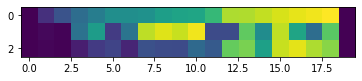

Actual: 0
Predicted: 0
YAY ✿(ᵔ‿ᵔ)


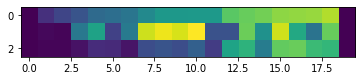

Actual: 1
Predicted: 1
YAY ✿(ᵔ‿ᵔ)


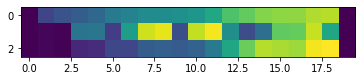

Actual: 2
Predicted: 2
YAY ✿(ᵔ‿ᵔ)


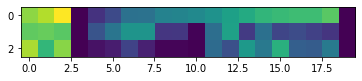

Actual: 18
Predicted: 18
YAY ✿(ᵔ‿ᵔ)


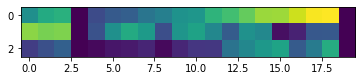

Actual: 13
Predicted: 13
YAY ✿(ᵔ‿ᵔ)


In [19]:
for i in range(5):
    handTest(i, test_data, test_labels, skeleton_model, numb_test)

Train input


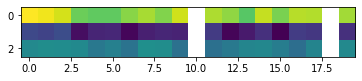

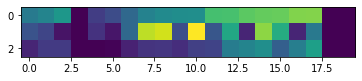

Test input


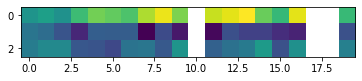

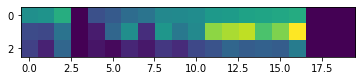

In [20]:
index = 1234
frame = int(index/20)

print("Train input")
plt.imshow(pre_train_data[frame].reshape(3,20))
plt.show()
# DIMENTION CHANGE
# plt.imshow(train_data[index].reshape(3,13))
plt.imshow(train_data[index].reshape(3,20))
plt.show()

print("Test input")
plt.imshow(pre_test_data[frame].reshape(3,20))
plt.show()
# plt.imshow(test_data[index].reshape(3,13))
plt.imshow(test_data[index].reshape(3,20))
plt.show()

In [21]:
temporal = loadmat('mat_files/test_temportal_new.mat')

In [65]:
file_times = temporal['combed']
time_data = file_times.reshape((len(file_times), 3*file_times.shape[2]))
# print(time_data.shape)
# print(time_data[0])

In [215]:
numb_times = 200
index_time = np.linspace(0, len(time_data), num = numb_times, endpoint=False).astype(int)
select_time = time_data[index_time]
input_time = select_time.reshape(select_time.shape[0], 3, int(select_time.shape[1]/3)).astype(float)
print(input_time.shape)
# print(input_time[0])

(200, 3, 22)


In [214]:
processed_time = getData(input_time, numb_times)
print(processed_time.shape)

(4400, 60)


In [25]:
# print("Showing input measurements")
# for i in range(420, 423):
#     plt.imshow(processed_time[i].reshape(3, 20))
#     plt.show()

In [465]:
import progressbar

def temporalpredict(data, model):
    pred = []
    pred_max = []
    pred_cert = []

    zeros = np.zeros((60))
    bar = progressbar.ProgressBar()
    for i in bar(range(len(data))):        
        if(np.array_equal(zeros,np.array(data[i]))):
            pred.append(np.zeros((20)))
            pred_max.append(np.nan)
            pred_cert.append(0.0)
        else:
            pred_model = model.predict(data[i].reshape(1, 60))
            pred.append(pred_model[0])
            pred_max.append(pred_model.argmax())
            pred_cert.append(pred_model.max())
    pred = np.array(pred)
    pred_max = np.array(pred_max)
    pred_cert = np.array(pred_cert)

    return pred, pred_max, pred_cert

In [466]:
pred, pred_max, pred_cert = temporalpredict(processed_time, skeleton_model)

100% (4400 of 4400) |####################| Elapsed Time: 0:02:29 Time:  0:02:29


In [537]:
import numpy as np
from scipy import stats

pt_max = pred_max.reshape(numb_times, input_time.shape[2])
pt_cert = pred_cert.reshape(numb_times, input_time.shape[2])

mode = stats.mode(pt_max,  axis = 0)
pred_init = mode[0].flatten()
pred_count= mode[1].flatten()
pred_trans = pt_max.T

certainty_pred = []
non_nan = []
for i in range(len(pred_init)):
    cert_array= pt_cert[np.where(pt_max == pred_init[i])]
    certainty_pred.append(sum(cert_array)/len(cert_array))
    non_nan.append(sum(~np.isnan(pred_trans[i])))
certainty_pred = np.array(certainty_pred)
counted_percent = np.array(pred_count/non_nan)


print("Initial predition:\n", pred_init)
print("Confidence mode is correct:\n", certainty_pred)
print("Percent mode appeared:\n", counted_percent)
print(pt_max.shape)

Initial predition:
 [ 2.  0.  0.  0.  8. 17. 17. 15. 17.  8.  6. 18.  3. 15. 18.  8. 10. 15.
 12. 12. 19. 18.]
Confidence mode is correct:
 [0.94895595 0.98810557 0.98810557 0.98810557 0.83827565 0.70468124
 0.70468124 0.66768211 0.70468124 0.83827565 0.6629918  0.66466021
 0.75304715 0.66768211 0.66466021 0.83827565 0.5123005  0.66768211
 0.56424927 0.56424927 0.63800513 0.66466021]
Percent mode appeared:
 [1.         1.         0.995      0.98       0.78       0.585
 0.745      0.55294118 0.51530612 0.57360406 0.665      0.4974359
 0.84       0.38961039 0.27419355 0.46875    0.32142857 0.515625
 0.28272251 0.6557377  0.5125     0.51351351]
(200, 22)


In [468]:
pt_pred = pred.reshape(numb_times, input_time.shape[2], 20)

In [545]:
def manual(pred):
    predict = pred.copy()
    pred_all = []
    pred_cert = []

    zeros = np.zeros((20))

    for i in range(len(predict)):
        temp_all = []
        temp_cert = []
        for j in range(20):
            if(np.array_equal(zeros,np.array(predict[i]))):
                temp_all.append(np.nan)
                temp_cert.append(np.nan)
            else:
                current = predict[i]
                temp_all.append(current.argmax())
                temp_cert.append(current.max())
                current[current.argmax()] = 0.0
        pred_all.append(temp_all)
        pred_cert.append(temp_cert)
    pred_all = np.array(pred_all).T.reshape(20,200,22)
    pred_cert = np.array(pred_cert).T.reshape(20,200,22)
    return pred_all, pred_cert

In [576]:
pred_all, conf_all = manual(pred)

In [642]:
predictions = []
for level in range(20):
    pt_max = pred_all[level]
    pt_cert = conf_all[level]

    temp_mode = np.array(stats.mode(pt_max, axis = 0))
    pred_init = temp_mode[0].flatten()
    pred_count = temp_mode[1].flatten()
    certainty_pred = []
    non_nan = []

    for i in range(len(pred_init)):
        # index of where the mode predicted index is also the same as the predicted index per frame
        cert_array = np.array(np.where(pt_max.T[i] == pred_init[i])).flatten()
        cert_sum = np.take(pt_cert.T[i], cert_array)
        certainty_pred.append(sum(cert_sum)/len(cert_sum))
        non_nan.append(sum(~np.isnan(pt_max.T[i])))

    certainty_pred = np.array(certainty_pred)
    counted_percent = np.array(pred_count/non_nan)
    predictions.append([pred_init, certainty_pred, counted_percent])


In [643]:
print(predictions[2])

[array([13., 17., 17.,  8., 17.,  8.,  8., 11., 16., 17., 17.,  9.,  4.,
       14., 19., 17., 11., 11., 13., 14., 14., 17.]), array([1.51779129e-03, 6.47553504e-07, 1.58597879e-07, 8.31327369e-04,
       3.92480934e-03, 6.02339387e-02, 3.89658058e-02, 1.92627938e-02,
       8.62874484e-02, 1.22366322e-01, 3.87258366e-02, 4.57895670e-02,
       4.70255740e-02, 1.27982038e-01, 9.09038607e-02, 3.48307705e-02,
       6.22201778e-02, 8.03313019e-02, 9.73514743e-02, 9.00449242e-03,
       6.09174855e-02, 2.86643752e-02]), array([0.465     , 0.505     , 0.38      , 0.395     , 0.305     ,
       0.325     , 0.495     , 0.36470588, 0.33163265, 0.41624365,
       0.195     , 0.66666667, 0.19      , 0.41558442, 0.16129032,
       0.4375    , 0.32142857, 0.4453125 , 0.32984293, 0.44262295,
       0.3875    , 0.44144144])]
